<a href="https://colab.research.google.com/github/DimaKav/DS-Unit-2-Sprint-2-Linear-Regression/blob/master/module2-polynomial-regression/Polynomial_Log_linear_Regression_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intermediate Linear Regression Practice

## Use a Linear Regression model to get the lowest RMSE possible on the following dataset:

[Dataset Folder](https://github.com/ryanleeallred/datasets/tree/master/Ames%20Housing%20Data)

[Raw CSV](https://raw.githubusercontent.com/ryanleeallred/datasets/master/Ames%20Housing%20Data/train.csv)

## You model must include (at least):
- A log-transformed y variable
- Two polynomial features
- One interaction feature
- 10 other engineered features

What is the lowest Root-Mean-Squared Error that you are able to obtain? Share your best RMSEs in Slack!

Notes:

There may be some data cleaning that you need to do on some features of this dataset. Linear Regression will only accept numeric values and will not accept

Note* There may not be a clear candidate for an interaction term in this dataset. Include one anyway, sometimes it's a good practice for predictive modeling feature engineering in general. 

RMSE: how much percent is the prediction off by

# Imports

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
%config InlineBackend.figure_format='retina'

# Feature Engineering Part I

In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/ryanleeallred/datasets/master/Ames%20Housing%20Data/train.csv')
df.shape

(1460, 81)

In [0]:
df.columns.sort_values()

Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'Alley', 'BedroomAbvGr',
       'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath',
       'BsmtQual', 'BsmtUnfSF', 'CentralAir', 'Condition1', 'Condition2',
       'Electrical', 'EnclosedPorch', 'ExterCond', 'ExterQual', 'Exterior1st',
       'Exterior2nd', 'Fence', 'FireplaceQu', 'Fireplaces', 'Foundation',
       'FullBath', 'Functional', 'GarageArea', 'GarageCars', 'GarageCond',
       'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt', 'GrLivArea',
       'HalfBath', 'Heating', 'HeatingQC', 'HouseStyle', 'Id', 'KitchenAbvGr',
       'KitchenQual', 'LandContour', 'LandSlope', 'LotArea', 'LotConfig',
       'LotFrontage', 'LotShape', 'LowQualFinSF', 'MSSubClass', 'MSZoning',
       'MasVnrArea', 'MasVnrType', 'MiscFeature', 'MiscVal', 'MoSold',
       'Neighborhood', 'OpenPorchSF', 'OverallCond', 'OverallQual',
       'PavedDrive', 'PoolArea', 'Po

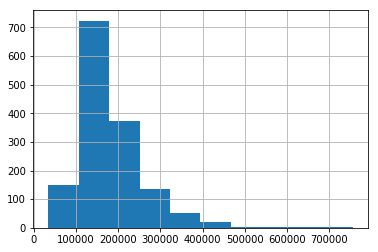

In [0]:
df.SalePrice.hist()

Looks a bit skewed to the left, let's log transform it.

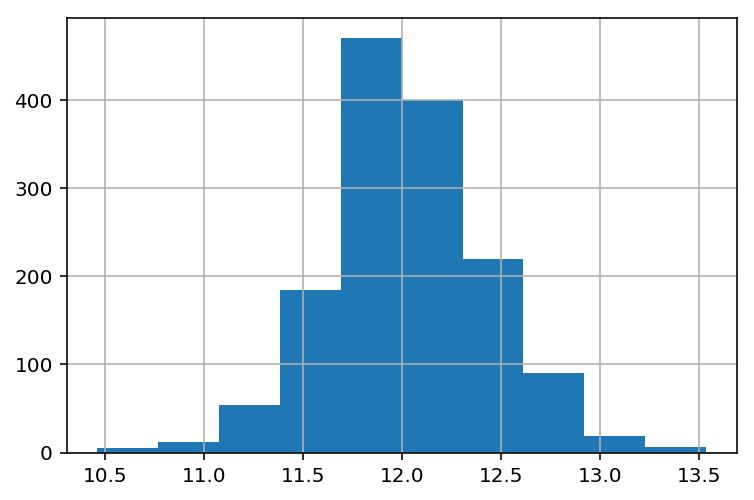

In [0]:
df['ln_price'] = np.log(df['SalePrice'])
df['ln_price'].hist()

Much better

#### Let's see the features we should pick

In [0]:
df.corr()['ln_price'].sort_values()[-20:]

2ndFlrSF        0.319300
OpenPorchSF     0.321053
WoodDeckSF      0.334135
LotFrontage     0.355878
BsmtFinSF1      0.372023
MasVnrArea      0.430809
Fireplaces      0.489449
TotRmsAbvGrd    0.534422
GarageYrBlt     0.541073
YearRemodAdd    0.565608
YearBuilt       0.586570
FullBath        0.594771
1stFlrSF        0.596981
TotalBsmtSF     0.612134
GarageArea      0.650888
GarageCars      0.680625
GrLivArea       0.700927
OverallQual     0.817184
SalePrice       0.948374
ln_price        1.000000
Name: ln_price, dtype: float64

Pull these out, see if they have any nans

Let's use features that are > 50% Pearson correlated

In [0]:
df.isna().sum().sort_values()[-20:]

RoofStyle          0
Electrical         1
MasVnrType         8
MasVnrArea         8
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
BsmtFinType2      38
BsmtExposure      38
GarageYrBlt       81
GarageType        81
GarageFinish      81
GarageCond        81
GarageQual        81
LotFrontage      259
FireplaceQu      690
Fence           1179
Alley           1369
MiscFeature     1406
PoolQC          1453
dtype: int64

In [0]:
df[['YearBuilt','GarageYrBlt']].corr()

,YearBuilt,GarageYrBlt
YearBuilt,1.000000,0.825667
GarageYrBlt,0.825667,1.000000


GarageYrBuilt is the only one of our numeric features that has nan's, let's take care of those. Since it only accounts for about 5% of our data, we can just impute the values from the year the house was built, this will give just enough accuracy for a better model.

In [0]:
df['GarageYrBlt'].fillna(df['YearBuilt'], inplace=True)

There are more to be taken care of. We won't drop these hevily NaNd ones just yet as they could contain valuable small pieces of clues.

In [0]:
df.isna().sum().sort_values()[-5:]

FireplaceQu     690
Fence          1179
Alley          1369
MiscFeature    1406
PoolQC         1453
dtype: int64

In [0]:
df.shape

(1460, 82)

# Distribution of Chosen Features

In [0]:
features = [
'TotRmsAbvGrd',
'GarageYrBlt',
'YearRemodAdd',
'YearBuilt',
'FullBath',
'1stFlrSF',
'TotalBsmtSF',
'GarageArea',
'GarageCars',
'GrLivArea',
'OverallQual',
'ln_price',
'LotArea',
]

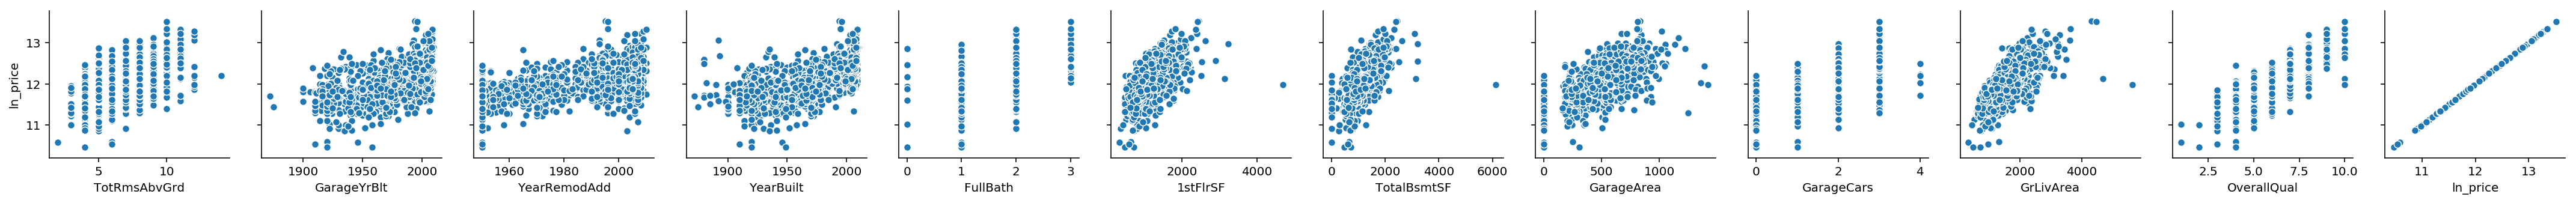

In [0]:
x_columns = features
sns.pairplot(data=df[features], y_vars=['ln_price'], x_vars=x_columns)

We have at least a few semi polynomial features in there

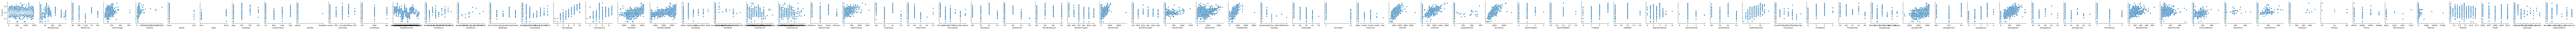

In [0]:
cols = df.iloc[:,:-2].columns
# df.iloc[:,:-2]
sns.pairplot(data=df, y_vars=['ln_price'], x_vars=cols)

# Multiple Regression

In [0]:
def run_regression(X, y):
    # Split data 80/20 for training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

    # Train the model using the training sets
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions using the testing set
    y_pred = model.predict(X_test)

    # Intercept value
    print("\nIntercept Value:", model.intercept_)

    # The slope coefficient
    print("Slope Coefficients:", model.coef_[0])

    # Root mean squared error
    print("RMSE: %.2f" % mean_squared_error(y_test, y_pred)**0.5)

    # Explained variance score: 1 is perfect prediction
    print('R^2: %.2f' % r2_score(y_test, y_pred))

In [0]:
X = df[features].drop(['ln_price'], axis=1)
y = df[['ln_price']]

In [0]:
X.shape, y.shape

((1460, 11), (1460, 1))

In [0]:
run_regression(X,y)


Intercept Value: [3.37479548]
Slope Coefficients: [ 1.36631611e-02 -9.38214377e-04  2.49319722e-03  2.17365753e-03
 -8.91890971e-05  5.87721677e-05  7.83233129e-05  6.30722502e-05
  7.60280020e-02  1.78610520e-04  9.78930558e-02]
RMSE: 0.16
R^2: 0.85


In [0]:
df.isna().sum().sort_values()[-10:]

GarageCond        81
GarageQual        81
GarageType        81
GarageFinish      81
LotFrontage      259
FireplaceQu      690
Fence           1179
Alley           1369
MiscFeature     1406
PoolQC          1453
dtype: int64

In [0]:
df.drop(['LotFrontage','FireplaceQu','Fence','Alley','MiscFeature','PoolQC'],inplace=True,axis=1)
df.dropna(inplace=True)
df.isna().sum().sum()

0

In [0]:
df.shape

(1338, 76)

In [0]:
f = df.select_dtypes('object')

In [0]:
df.apply(lambda x: pd.factorize(x)[0]).corr()['ln_price'].sort_values()[-10:]

OpenPorchSF    0.170694
GarageArea     0.285683
GrLivArea      0.288689
TotalBsmtSF    0.302712
BsmtUnfSF      0.304572
1stFlrSF       0.312408
LotArea        0.379632
Id             0.442796
SalePrice      1.000000
ln_price       1.000000
Name: ln_price, dtype: float64

In [0]:
df.head()

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,ln_price
0,1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,2,2008,WD,Normal,208500,12.247694
1,2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,5,2007,WD,Normal,181500,12.109011
2,3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,9,2008,WD,Normal,223500,12.317167
3,4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,0,2,2006,WD,Abnorml,140000,11.849398
4,5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,12,2008,WD,Normal,250000,12.429216


In [0]:
run_regression(X,y)


Intercept Value: [3.82369431]
Slope Coefficients: [ 1.21694679e-02 -1.35045153e-03  2.33284673e-03  2.51157703e-03
 -8.19280611e-03  4.93738628e-05  7.73871845e-05  8.04342184e-05
  8.07515811e-02  1.84215025e-04  1.01842889e-01]
RMSE: 0.16
R^2: 0.83


The **coefficient of determination R^2** indicates that 85% of the test instances prices are explained by the model. This also tells us how well the training model predicts new data. The closer R^2 is to one, the more the variance of the target vector is explained by the features.

The **mean squared error** is a measurnment of the squared sum of all distances between predicted and true values. The higher the MSE, the greater the total squared error. If the MSE was high, it would mean we have a bad model. In this case it's pretty low.

Let's create a function to do regression:

In [0]:
# Feature Engineering Part II: Creating More Features

In [0]:
df.columns.sort_values()

Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'Alley', 'BedroomAbvGr',
       'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath',
       'BsmtQual', 'BsmtUnfSF', 'CentralAir', 'Condition1', 'Condition2',
       'Electrical', 'EnclosedPorch', 'ExterCond', 'ExterQual', 'Exterior1st',
       'Exterior2nd', 'Fence', 'FireplaceQu', 'Fireplaces', 'Foundation',
       'FullBath', 'Functional', 'GarageArea', 'GarageCars', 'GarageCond',
       'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt', 'GrLivArea',
       'HalfBath', 'Heating', 'HeatingQC', 'HouseStyle', 'Id', 'KitchenAbvGr',
       'KitchenQual', 'LandContour', 'LandSlope', 'LotArea', 'LotConfig',
       'LotFrontage', 'LotShape', 'LowQualFinSF', 'MSSubClass', 'MSZoning',
       'MasVnrArea', 'MasVnrType', 'MiscFeature', 'MiscVal', 'MoSold',
       'Neighborhood', 'OpenPorchSF', 'OverallCond', 'OverallQual',
       'PavedDrive', 'PoolArea', 'Po

In [0]:
df['YrSold'].value_counts()

2009    338
2007    329
2006    314
2008    304
2010    175
Name: YrSold, dtype: int64

In [0]:
df['age'] = 2010 - df['YearBuilt']
df['age_squared'] = df['age']**2

In [0]:
df.corr()['ln_price'].sort_values()

age             -0.586570
age_squared     -0.474108
EnclosedPorch   -0.149050
KitchenAbvGr    -0.147548
MSSubClass      -0.073959
LowQualFinSF    -0.037963
YrSold          -0.037263
OverallCond     -0.036868
MiscVal         -0.020021
Id              -0.017942
BsmtHalfBath    -0.005149
BsmtFinSF2       0.004832
3SsnPorch        0.054900
MoSold           0.057329
PoolArea         0.069798
ScreenPorch      0.121208
BedroomAbvGr     0.209044
BsmtUnfSF        0.221985
BsmtFullBath     0.236224
LotArea          0.257320
HalfBath         0.313982
2ndFlrSF         0.319300
OpenPorchSF      0.321053
WoodDeckSF       0.334135
LotFrontage      0.355878
BsmtFinSF1       0.372023
interaction      0.409139
MasVnrArea       0.430809
Fireplaces       0.489449
TotRmsAbvGrd     0.534422
YearRemodAdd     0.565608
GarageYrBlt      0.568696
YearBuilt        0.586570
FullBath         0.594771
1stFlrSF         0.596981
TotalBsmtSF      0.612134
GarageArea       0.650888
GarageCars       0.680625
GrLivArea   

Let's add an interaction variable:

In [0]:
df['interaction'] = df['2ndFlrSF'] * df['TotalBsmtSF']

In [0]:
# Append interaction to our features and run the model
# Features
X = df[features].drop('ln_price', axis=1)
y = df[['ln_price']]

# Model
run_regression(X,y)


Intercept Value: [5.5094605]
Slope Coefficients: [-6.42028310e-04 -9.50565487e-04  2.28926375e-03  1.34833963e-03
 -4.03468176e-02 -1.51321542e-04  1.29206839e-04  1.07131667e-04
  7.12095079e-02  4.73450477e-04  8.56901714e-02 -1.34833963e-03
 -1.97550851e-07]
RMSE: 0.17
R^2: 0.84


In [0]:
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

# Featuretools

In [0]:
# put id in here
features = [
'Id',    
'TotRmsAbvGrd',
'GarageYrBlt',
'YearRemodAdd',
'YearBuilt',
'FullBath',
'1stFlrSF',
'TotalBsmtSF',
'GarageArea',
'GarageCars',
'GrLivArea',
'OverallQual',
'ln_price',
'age',
'interaction'
]

In [0]:
df.shape

(1338, 75)

In [0]:
df.isna().sum().sort_values()[-15:]

BsmtFinSF1      0
BsmtFinType1    0
BsmtExposure    0
BsmtCond        0
SalePrice       0
BsmtQual        0
ExterCond       0
ExterQual       0
MasVnrArea      0
MasVnrType      0
Exterior2nd     0
Exterior1st     0
RoofMatl        0
Foundation      0
ln_price        0
dtype: int64

In [0]:
df.drop(['LotFrontage','FireplaceQu','Fence','Alley','MiscFeature','PoolQC'],inplace=True,axis=1)

In [0]:
df.dropna(inplace=True)

In [0]:
sales = df['ln_price']
df.drop('ln_price',axis=1,inplace=True)

I dropped the nans resulting in a slightly smaller row shape, not bad still.

In [0]:
# creating and entity set 'es'
es = ft.EntitySet(id = 'houses')

# adding a dataframe 
es.entity_from_dataframe(entity_id = 'housing_iowa', dataframe = df, index = 'Id')

Entityset: houses
  Entities:
    housing_iowa [Rows: 1338, Columns: 74]
  Relationships:
    No relationships

In [0]:
feature_matrix, feature_names = ft.dfs(entityset=es,
agg_primitives = ['mean', 'max', 'percent_true', 'time_since_last', 
                  'num_unique','min','n_most_common','skew'],
trans_primitives = ['scalar_subtract_numeric_feature','percentile','diff','divide_by_feature',
                    'modulo_by_feature'],
target_entity = 'housing_iowa', max_depth = 2)

In [0]:
feature_matrix.shape

(1338, 423)

In [0]:
feature_matrix.dropna(axis='columns',inplace=True)

In [0]:
feature_matrix.drop(feature_matrix.select_dtypes('object'), axis=1, inplace=True)

In [0]:
features_and_price = feature_matrix.join(y)

In [0]:
features_and_price.dropna(inplace=True)

In [0]:
features_and_price.isna().sum().sum()

0

In [0]:
features_and_price.shape

(1337, 348)

Put in sales and see some corrs

In [0]:
features_and_price.corr()['ln_price'].sort_values()[:10]

1 / 0 - LowQualFinSF          -0.284406
1 / PoolArea                  -0.247564
1 / MiscVal                   -0.103136
1 / BsmtFinSF2                -0.080203
1 / BsmtHalfBath              -0.078725
1 / PERCENTILE(TotalBsmtSF)   -0.070629
1 / ScreenPorch               -0.066572
1 / Fireplaces                -0.050490
1 / PERCENTILE(GrLivArea)     -0.048145
1 % PERCENTILE(Fireplaces)    -0.047534
Name: ln_price, dtype: float64

In [0]:
features_and_price.corr()['ln_price'].dropna().sort_values()[-10:]

1 / 0 - Fireplaces           0.050490
1 / PERCENTILE(YearBuilt)    0.056579
1 % PERCENTILE(1stFlrSF)     0.062739
1 / 0 - ScreenPorch          0.066572
1 / 0 - BsmtHalfBath         0.078725
1 / 0 - BsmtFinSF2           0.080203
1 / 0 - MiscVal              0.103136
1 / 0 - PoolArea             0.247564
1 / LowQualFinSF             0.284406
ln_price                     1.000000
Name: ln_price, dtype: float64

In [0]:
features_and_price.isna().sum().sum()

0

In [0]:
features_and_price.shape

(1337, 348)

In [0]:
features_and_price.select_dtypes('object').count().sum()

0

In [0]:
features_and_price

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,1 % 1 / WoodDeckSF,1 % 1 / OpenPorchSF,1 % 1 / EnclosedPorch,1 % 1 / 3SsnPorch,1 % 1 / ScreenPorch,1 % 1 / PoolArea,1 % 1 / MiscVal,1 % 1 / MoSold,1 % 1 / YrSold,ln_price
Id,,,,,,,,,,,,,,,,,,,,,
1,60,8450,7,5,2003,2003,196.0,706,0,150,...,1.000000e+00,1.639344e-02,1.000000e+00,1.000000e+00,1.000000,1.0,1.000000e+00,0.000000e+00,1.734723e-17,12.109011
2,20,9600,6,8,1976,1976,0.0,978,0,284,...,2.168404e-17,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.0,1.000000e+00,2.000000e-01,3.892286e-17,12.317167
3,60,11250,7,5,2001,2002,162.0,486,0,434,...,1.000000e+00,5.551115e-17,1.000000e+00,1.000000e+00,1.000000,1.0,1.000000e+00,5.551115e-17,1.734723e-17,11.849398
4,70,9550,7,5,1915,1970,0.0,216,0,540,...,1.000000e+00,3.122502e-17,1.387779e-17,1.000000e+00,1.000000,1.0,1.000000e+00,0.000000e+00,8.023096e-17,12.429216
5,60,14260,8,5,2000,2000,350.0,655,0,490,...,5.551115e-17,5.551115e-17,1.000000e+00,1.000000e+00,1.000000,1.0,1.000000e+00,5.551115e-17,1.734723e-17,11.870600
6,50,14115,5,5,1993,1995,0.0,732,0,64,...,2.500000e-02,1.387779e-17,1.000000e+00,3.125000e-03,1.000000,1.0,8.673617e-19,1.000000e-01,3.198396e-17,12.634603
7,20,10084,8,5,2004,2005,186.0,1369,0,317,...,1.387779e-17,5.551115e-17,1.000000e+00,1.000000e+00,1.000000,1.0,1.000000e+00,0.000000e+00,3.892286e-17,12.206073
8,60,10382,7,6,1973,1973,240.0,859,32,216,...,4.255319e-03,1.387779e-17,5.551115e-17,1.000000e+00,1.000000,1.0,8.673617e-19,9.090909e-02,3.198396e-17,11.774520
9,50,6120,7,5,1931,1950,0.0,0,0,952,...,1.111111e-02,1.000000e+00,8.673617e-19,1.000000e+00,1.000000,1.0,1.000000e+00,0.000000e+00,1.734723e-17,11.678440


# Stretch Goals

- Write a blog post explaining one of today's topics.
- Find a new regression dataset from the UCI machine learning repository and use it to test out your new modeling skillz.
 [ - UCI Machine Learning Repository - Regression Datasets](https://)
- Make a list for yourself of common feature engineering techniques. Browse Kaggle kernels to learn more methods.
- Start studying for tomorrow's topic: Gradient Descent
- Try and make the ultimate model with this dataset. clean as many features as possible, engineer the most sensible features as possible and see how accurate of a prediction you can make. 
- Learn about the "Dummy Variable Trap" and how it applies to linear regression modeling.
- Learning about using linear regression to model time series data